# Health Report Anomaly Detector: Cluster-Based Insights into Abnormalities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("anomaly_detect.xlsx", engine="openpyxl")


In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [5]:
df.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

In [6]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [7]:
df["gender"] = df["gender"].map({1: 0, 2: 1})


In [8]:
multi_cat_cols = ["cholesterol", "gluc"]
df = pd.get_dummies(df, columns=multi_cat_cols, prefix=multi_cat_cols)

In [9]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0,18393,1,168,62.0,110,80,0,0,1,0,True,False,False,True,False,False
1,1,20228,0,156,85.0,140,90,0,0,1,1,False,False,True,True,False,False
2,2,18857,0,165,64.0,130,70,0,0,0,1,False,False,True,True,False,False
3,3,17623,1,169,82.0,150,100,0,0,1,1,True,False,False,True,False,False
4,4,17474,0,156,56.0,100,60,0,0,0,0,True,False,False,True,False,False


Fixing age column

In [10]:
df['age']=(df['age']/365).round().astype(int)

In [11]:
for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype(int)


In [12]:
df.drop(columns=['id','cardio'])

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,50,1,168,62.0,110,80,0,0,1,1,0,0,1,0,0
1,55,0,156,85.0,140,90,0,0,1,0,0,1,1,0,0
2,52,0,165,64.0,130,70,0,0,0,0,0,1,1,0,0
3,48,1,169,82.0,150,100,0,0,1,1,0,0,1,0,0
4,48,0,156,56.0,100,60,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,53,1,168,76.0,120,80,1,0,1,1,0,0,1,0,0
69996,62,0,158,126.0,140,90,0,0,1,0,1,0,0,1,0
69997,52,1,183,105.0,180,90,0,1,0,0,0,1,1,0,0
69998,61,0,163,72.0,135,80,0,0,0,1,0,0,0,1,0


In [13]:
x=df.copy()

In [14]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
x_scaled=scaler.fit_transform(x)

In [15]:
from sklearn.cluster import DBSCAN

dbscan=DBSCAN(eps=2.0,min_samples=20)
labels=dbscan.fit_predict(x_scaled)

In [16]:
df["cluster"]=labels
df["anomalities"]= (labels==-1).astype(int)

In [17]:
df.dtypes

id                 int64
age                int64
gender             int64
height             int64
weight           float64
ap_hi              int64
ap_lo              int64
smoke              int64
alco               int64
active             int64
cardio             int64
cholesterol_1      int64
cholesterol_2      int64
cholesterol_3      int64
gluc_1             int64
gluc_2             int64
gluc_3             int64
cluster            int64
anomalities        int64
dtype: object

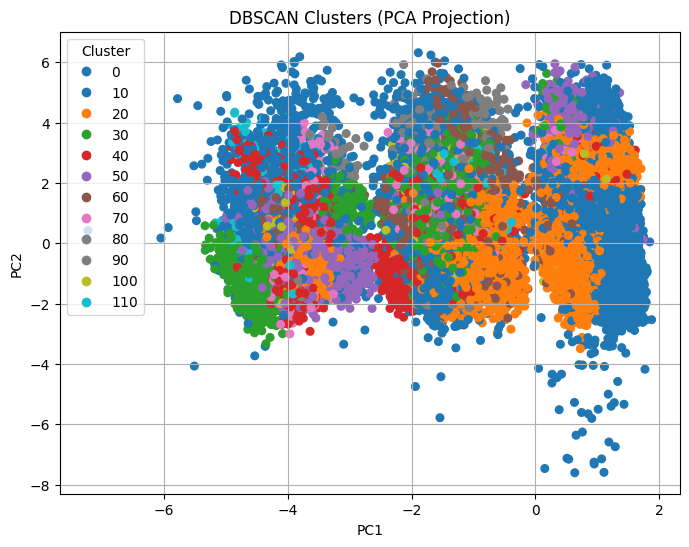

In [18]:
from sklearn.decomposition import PCA

pca =PCA(n_components=2)
pcs=pca.fit_transform(x_scaled)

plot_df = pd.DataFrame(pcs, columns=["PC1", "PC2"])
plot_df["cluster"] = labels

plt.figure(figsize=(8, 6))
scatter=plt.scatter(plot_df["PC1"], plot_df["PC2"], c=plot_df["cluster"], cmap="tab10", s=30)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.title("DBSCAN Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

#### Applied DBSCAN and projected high-dimensional health data into 2D using PCA, which helps us visualize the structure ,where:-

we seeing clusters of similar patient records (in terms of age, BP, cholesterol, glucose, etc.) compressed into a 2D space. But the high number of clusters suggests you should tune your parameters to reduce noise and avoid overfitting patterns.


### Mapping Clusters to Health Risk Profiles
Now, we go beyond detecting whether a data point is simply an "anomaly." Instead, we apply basic clinical logic to interpret what potential health risks a person may be prone to, based on abnormal values in their health report.

In [20]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,cluster,anomalities
0,0,50,1,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,0,0
1,1,55,0,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,1,0
2,2,52,0,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,2,0
3,3,48,1,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0,3,0
4,4,48,0,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0,4,0


In [21]:
def risk_profile(row):
    risks = []
    if row["ap_hi"] > 140 or row["ap_lo"] > 90:
        risks.append("Hypertension")
    if row["weight"] > 90:
        risks.append("Obesity")
    if row["gluc_2"] == 1 or row["gluc_3"] == 1:
        risks.append("High Glucose")
    if row["cholesterol_2"] == 1 or row["cholesterol_3"] == 1:
        risks.append("High Cholesterol")
    if row["smoke"] == 1:
        risks.append("Smoker Risk")
    return ", ".join(risks) if risks else "Normal"

df["health_risks"] = df.apply(risk_profile, axis=1)

In [22]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,cluster,anomalities,health_risks
0,0,50,1,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,0,0,Normal
1,1,55,0,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,1,0,High Cholesterol
2,2,52,0,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,2,0,High Cholesterol
3,3,48,1,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0,3,0,Hypertension
4,4,48,0,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0,4,0,Normal


In [25]:
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

df["true_label"] = (df["health_risks"] != "Normal").astype(int)
confusion_matrix(df["true_label"], df["anomalities"])
print(classification_report(df["true_label"], df["anomalities"]))
roc_auc_score(df["true_label"], df["anomalities"])

              precision    recall  f1-score   support

           0       0.53      1.00      0.69     35862
           1       0.96      0.07      0.12     34138

    accuracy                           0.54     70000
   macro avg       0.74      0.53      0.41     70000
weighted avg       0.74      0.54      0.41     70000



np.float64(0.5313816718064863)